# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA, но уже 64x64

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [ ]:
ON_COLAB = False

if ON_COLAB:
    ! git clone https://github.com/SpirinEgor/HSE.gans.git
    % cd HSE.gans

In [21]:
import fileinput
from math import log
from os import makedirs
from os.path import exists, join

import numpy as np
import requests
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm.auto import trange, tqdm

from homework_3.glow import Glow
from homework_3.vae import Vae64x64

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%capture

! pip install --upgrade --no-cache-dir gdown

In [3]:
url = "https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/utils/datasets/celeba.py"
if not exists("celeba.py"):
    with open("celeba.py", "wb") as f:
        f.write(requests.get(url).content)

for line in fileinput.input("celeba.py", inplace=True):
    if fileinput.filelineno() not in [45, 46]:
        print(line[:-1])
        continue
    if fileinput.filelineno() == 45:
        corrected_line = "                download_url = 'https://drive.google.com/file/d/17NNnHn1RyPPmb4iQqIGJ2XFulfwyW1Sh/view?usp=sharing'"
    else:
        corrected_line = "                gdown.download(download_url, download_path, quiet=False, fuzzy=True)"
    print(corrected_line)

url = "https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt"
if not exists("list_attr_celeba.txt"):
    with open("list_attr_celeba.txt", "wb") as f:
        f.write(requests.get(url).content)

from celeba import CelebADataset

Мы будем использовать урезанный датасет (`crop=True`) для быстрой загрузки на диск.

Для обучения модели вам нужно будет загрузить полную версию датасета.

Перед отправкой тетрадки в автопроверку ***ПРОВЕРЬТЕ*** что `crop=True`, иначе ваше решение будет таймаутиться

In [75]:
class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image

### Визуализация датасета

In [5]:
def plot_img(img):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")

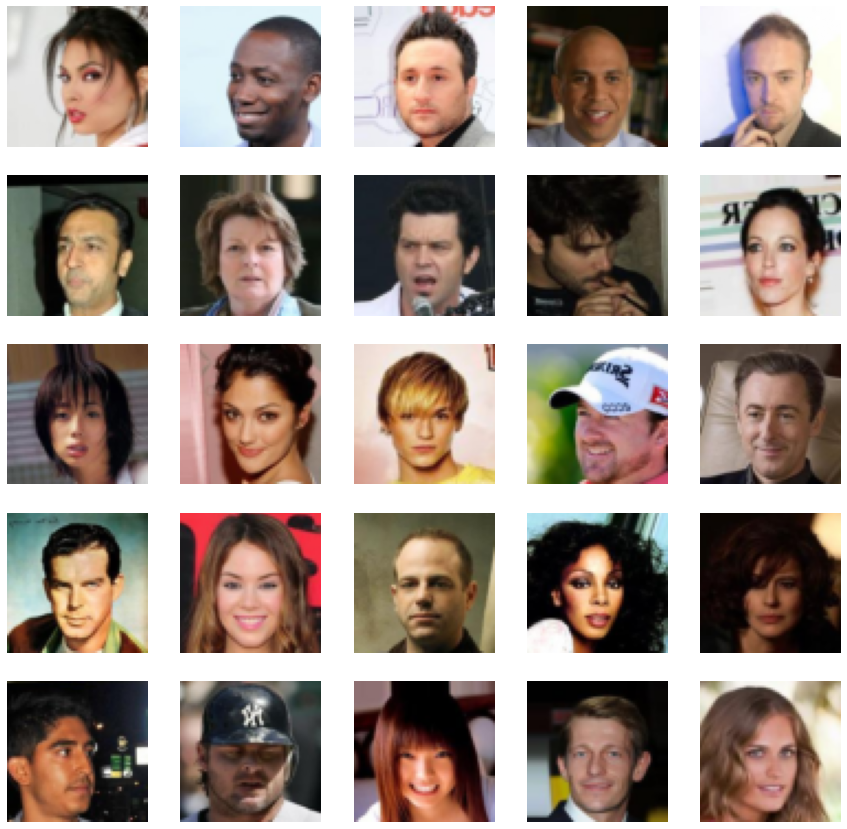

In [6]:
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img)

plt.show()

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [12]:
CHECKPOINT_DIR = "checkpoints"
SAMPLES_DIR = "samples"
makedirs(CHECKPOINT_DIR, exist_ok=True)
makedirs(SAMPLES_DIR, exist_ok=True)


def calc_size(net):
    param_size = 0
    for param in net.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in net.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    gen_size = (param_size + buffer_size) / 1024**2
    return gen_size

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA 64x64

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но он довольно плохой и неэффективный) Лучше написать свой

In [96]:
def glow_loss(log_p, log_det, n_bins, image_size):
    n_pixel = image_size * image_size * 3

    loss = -log(n_bins) * n_pixel
    loss += log_det + log_p

    return (-loss / (log(2) * n_pixel)).mean()


def train_glow(
    model, train_dataset, n_epochs: int = 20, lr: float = 1e-3, batch_size: int = 16, n_bits: int = 5, temp: float = 0.7
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    n_bins = 2.0**n_bits

    z_noise = model.prepare_sample_noise(n_samples=25, img_size=train_dataset[0].shape[-1])
    z_noise = [it.to(device) * temp for it in z_noise]

    model.eval()
    with torch.no_grad():
        sampled_images = model.reverse(z_noise).detach().cpu()
        sampled_images = sampled_images.clamp(-0.5, 0.5) + 0.5
    utils.save_image(sampled_images, join(SAMPLES_DIR, f"glow_epoch_0.png"), nrow=5, padding=5)

    losses = []
    is_init = False
    for e in trange(n_epochs, desc="Epoch"):
        with tqdm(dataloader, desc="Training", leave=False) as pbar:
            model.train()
            for images in pbar:
                images = images.to(device) * 255

                if n_bits < 8:
                    images = torch.floor(images / 2 ** (8 - n_bits))

                images = images / n_bins - 0.5

                noise = torch.zeros_like(images).uniform_(0, 1.0 / n_bins)

                # init glow modules
                if not is_init:
                    with torch.no_grad():
                        log_p, log_det, _ = model(images + noise)
                    is_init = True
                    continue

                log_p, log_det, _ = model(images + noise)
                log_det = log_det.mean()
                loss = glow_loss(log_p, log_det, n_bits, images.shape[-1])

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())
                pbar.set_postfix({"loss": losses[-1]})

        torch.save(model.state_dict(), join(CHECKPOINT_DIR, f"glow_epoch_{e + 1}.ckpt"))

        model.eval()
        with torch.no_grad():
            sampled_images = model.reverse(z_noise).detach().cpu()
            sampled_images = sampled_images.clamp(-0.5, 0.5) + 0.5
        utils.save_image(sampled_images, join(SAMPLES_DIR, f"glow_epoch_{e + 1}.png"), nrow=5, padding=5)

        scheduler.step()

    return losses

In [113]:
glow_celeba = Glow(k_flow=32, l_block=4, n_filters=256).to(device)

transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

dataset = CelebaCustomDataset(transform=transform, attr_file_path="list_attr_celeba.txt", crop=True)

print(f"model size: {calc_size(glow_celeba):.3f} MB")
glow_losses = train_glow(glow_celeba, dataset)

model size: 117.971 MB


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

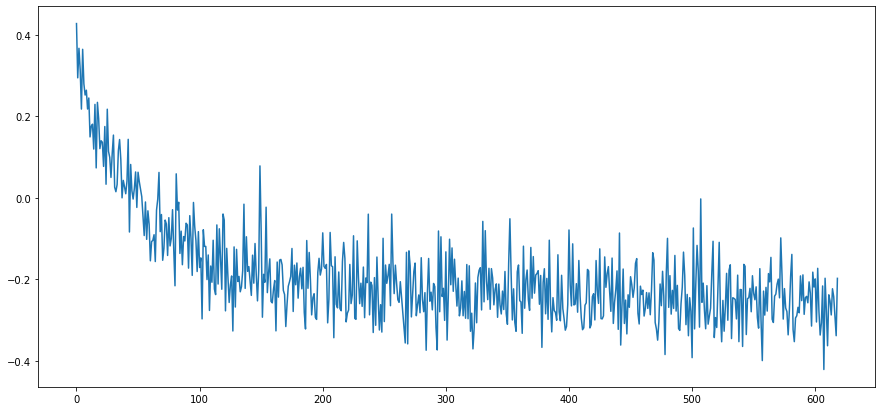

In [114]:
plt.figure(figsize=(15, 7))
plt.plot(glow_losses)
plt.show()

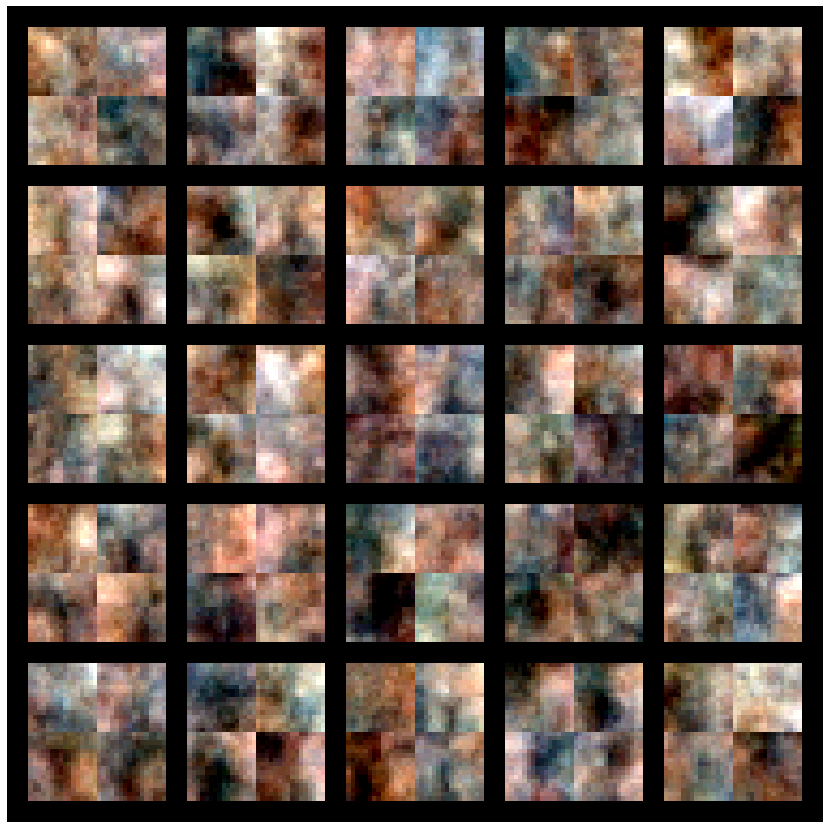

In [115]:
z_noise = glow_celeba.prepare_sample_noise(n_samples=25, img_size=32)
z_noise = [it.to(device) * 0.7 for it in z_noise]

img = glow_celeba.reverse(z_noise).detach().cpu()
img = img.clamp(-0.5, 0.5) + 0.5

plt.figure(figsize=(15, 15))
grid = utils.make_grid(img, nrow=5, padding=5)
plot_img(grid)

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA 64x64

Здесь нужно обучить VAE до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [119]:
def vae_loss(x, reconstruct, mu, log_sigma, kld_lambda: float = 1.0):
    element_wise = F.mse_loss(x, reconstruct, reduction="none")
    reconstruction_loss = element_wise.reshape(x.shape[0], -1).sum(dim=1).mean()

    kld_loss = (0.5 * (torch.exp(2 * log_sigma) + mu**2 - 2 * log_sigma - 1)).sum(dim=1).mean()

    loss = reconstruction_loss + kld_lambda * kld_loss
    return loss


def train_vae_celeba(model, train_dataset, n_epochs: int = 3, lr: float = 0.001, batch_size: int = 16):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    z_noise = torch.rand(25, model.latent_dim).to(device)

    model.eval()
    with torch.no_grad():
        sampled_images = model.decode(z_noise).detach().cpu()
        sampled_images = (sampled_images + 1) / 2
        utils.save_image(sampled_images, join(SAMPLES_DIR, f"vae_epoch_0.png"), normalize=True, nrow=5, padding=5)

    losses = []
    for e in trange(n_epochs, desc="Epoch"):
        with tqdm(dataloader, desc="Training", leave=False) as pbar:
            model.train()
            for images in pbar:
                images = images.to(device)
                images = 2 * images - 1

                reconstruct, z, mu, log_sigma = model(images)
                loss = vae_loss(images, reconstruct, mu, log_sigma)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())
                pbar.set_postfix({"loss": losses[-1]})

        torch.save(model.state_dict(), join(CHECKPOINT_DIR, f"vae_epoch_{e + 1}.ckpt"))

        model.eval()
        with torch.no_grad():
            sampled_images = model.decode(z_noise).detach().cpu()
            sampled_images = (sampled_images + 1) / 2
        utils.save_image(sampled_images, join(SAMPLES_DIR, f"vae_epoch_{e + 1}.png"), normalize=True, nrow=5, padding=5)

    return losses

In [120]:
vae_celeba = Vae64x64(latent_dim=1024).to(device)

transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

dataset = CelebaCustomDataset(transform=transform, attr_file_path="list_attr_celeba.txt", crop=True)

print(f"model size: {calc_size(vae_celeba):.3f} MB")
vae_losses = train_vae_celeba(vae_celeba, dataset)

model size: 36.039 MB


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

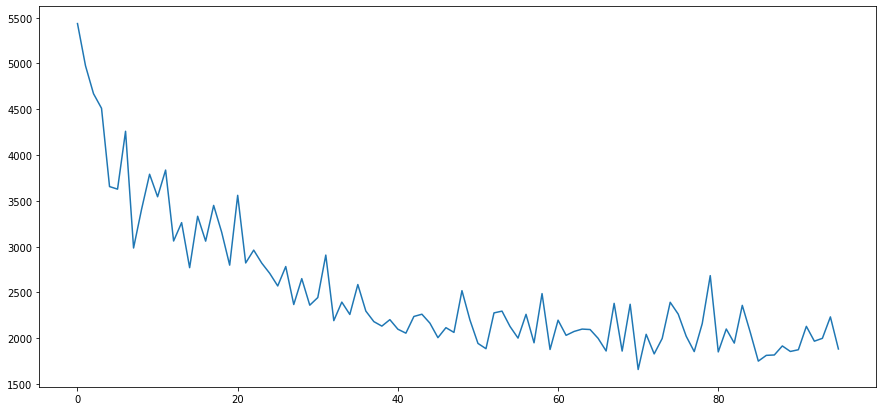

In [121]:
plt.figure(figsize=(15, 7))
plt.plot(vae_losses)
plt.show()

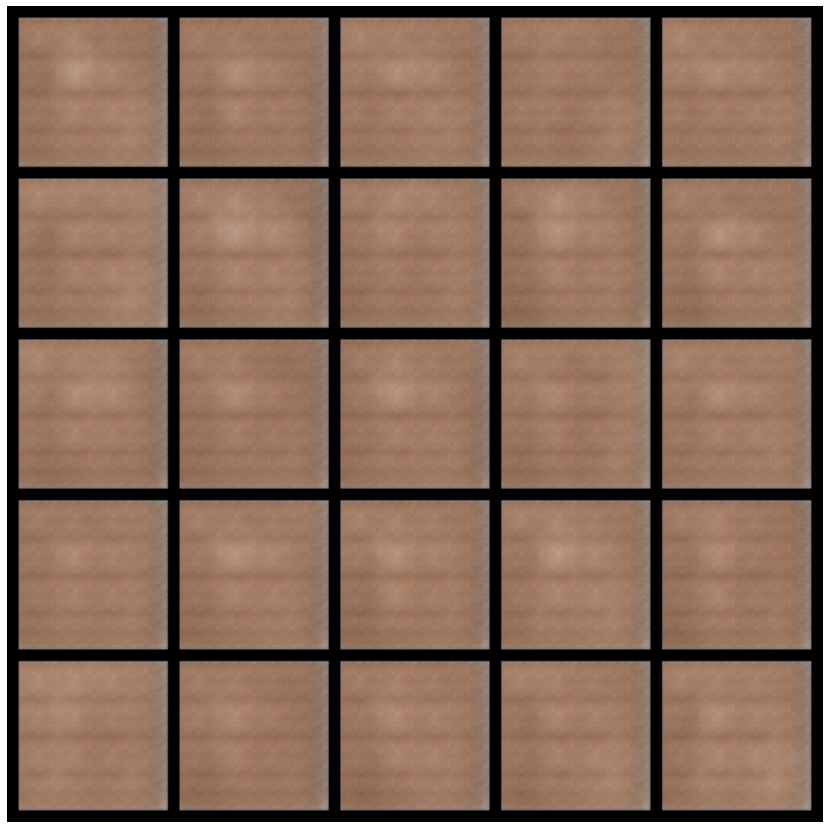

In [122]:
z_noise = torch.rand(25, vae_celeba.latent_dim).to(device)
img = vae_celeba.decode(z_noise).detach().cpu()
img = (img + 1) / 2

plt.figure(figsize=(15, 15))
grid = utils.make_grid(img, nrow=5, padding=5)
plot_img(grid)

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA 64x64

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA 64x64

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [ ]:
# YOUR CODE HERE

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

In [ ]:
# YOUR CODE HERE

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.